# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [39]:
# using SQLite Table to read data.
con = sqlite3.connect('drive/My Drive/FFRDB/database.sqlite')

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 150000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (150000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [40]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [41]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [42]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [43]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [44]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [45]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [46]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(126359, 10)

In [47]:
final.sort_values('Time',inplace=True)
print(final.head(5))

            Id  ...                                               Text
138706  150524  ...  this witty little book makes my son laugh at l...
138683  150501  ...  I can remember seeing the show when it aired o...
70688    76882  ...  I bought a few of these after my apartment was...
1146      1245  ...  This was a really good idea and the final prod...
1145      1244  ...  I just received my shipment and could hardly w...

[5 rows x 10 columns]


In [48]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

84.23933333333333

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [49]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [50]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [51]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(126357, 10)


1    106326
0     20031
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [52]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
These are very tasty especially the blueberries.  A bit pricy but not when compared to things like this at whole foods and other upscale stores.  I am ordering more for a road trip in my van when fresh fruit may be limited.
The sugarless mix is very satisfactory and it's fewer calories. Go for it.
So full of WHOLE wheat that it leaves a few hulls in your teeth after eating.  A little sweetness in the cracker makes it fine for sweet as well as savory toppings.  Even good eaten plain as a snack.


In [53]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [54]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
These are very tasty especially the blueberries.  A bit pricy but not when compared to things like this at whole foods and other upscale stores.  I am ordering more for a road trip in my van when fresh fruit may be limited.
The sugarless mix is very satisfactory and it's fewer calories. Go for it.
So full of WHOLE wheat that it leaves a few hulls in your teeth after eating.  A little sweetness in the cracker makes it fine for sweet as well as savory toppings.  Even good eaten plain as a snack.


In [55]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [56]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

The sugarless mix is very satisfactory and it is fewer calories. Go for it.


In [57]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [58]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

The sugarless mix is very satisfactory and it is fewer calories Go for it 


In [59]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [60]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 126357/126357 [00:49<00:00, 2574.30it/s]


In [61]:
preprocessed_reviews[1500]

'sugarless mix satisfactory fewer calories go'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [62]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.3] TF-IDF

In [63]:
preprocessed_reviews=preprocessed_reviews[:100000]

In [64]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=2000)
tfidf = tf_idf_vect.fit_transform(preprocessed_reviews)

In [65]:
print(tfidf.shape)

(100000, 2000)


# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

In [110]:
## using upto 10 cluster centers
NumCenters = range(2,20)
#defining a fucntion to return inertia for every set of cluster center used

def Inertia(NumCenters,data):
  from sklearn.cluster import KMeans
  Inertia=[]
  for i in NumCenters:

      clf = KMeans(n_clusters=i, init='k-means++', verbose=5, n_jobs=-1)
      clf.fit(data)
      kmeans=clf.inertia_
      Inertia.append(kmeans)  
  return Inertia


# plotting The Inertia vs K graph

def PlotElbow(NumCenters,Inertia):
  plt.plot(NumCenters, Inertia)
  plt.xlabel('K-values',size=15)
  plt.ylabel('Inertia',size=15)
  plt.title('Inertia VS K-values Plot\n',size=20)
  plt.grid()
  plt.show()

  '''
Algorithm to find elbow of a graph is taken from the following questionare on Stackoverflow
#######
https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve
#######
'''

# finding the Elbow of graph

def ElbowFinder(Inertia):
  import numpy as np
  import numpy.matlib
  nPoints = len(Inertia)
  allCoord = np.vstack((range(nPoints), Inertia)).T
  np.array([range(nPoints), Inertia])
  firstPoint = allCoord[0]
  lineVec = allCoord[-1] - allCoord[0]
  lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
  vecFromFirst = allCoord - firstPoint
  scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
  vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
  vecToLine = vecFromFirst - vecFromFirstParallel
  distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
  return np.argmax(distToLine)






from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

# Generating word cloud function for a given dataset of str

def ShowWordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    
    
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()  



# overall function to generate graph and word cloud

def PrintWordcloud(preprocessed_reviews,vectorizer):

# finding inertia and plotting it against different no of cluster
  inertia=Inertia(NumCenters,vectorizer)
  print('Plotting elbow graph')
  PlotElbow(NumCenters,inertia)
  print('\n\n')
# defining kmeans with best K
  from sklearn.cluster import KMeans
  clf= KMeans(n_clusters=ElbowFinder(inertia), n_jobs=-1)
  model=clf.fit(vectorizer)
  labels=model.labels_
# printing all cluters
  unq_labels=np.unique(labels)
  print('All clusters are',unq_labels)
  print("\n")

  corpus = preprocessed_reviews
# list of list containing reviews belonging to each cluster
  ListOfReviewsClusters=[[] for i in unq_labels]
# segregating reviews from each cluster
  for index,word in enumerate(corpus):
    real_label = labels[index]
    ListOfReviewsClusters[real_label].append(word) 
# printing each review cloud
  for i in range(len(list(unq_labels))):
    print('word cloud for cluster', i+1)
    ShowWordcloud(ListOfReviewsClusters[i])
    print('\n\n')
       

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [70]:
tfidf_feat=tf_idf_vect.get_feature_names()

In [72]:
len(tfidf_feat)

2000

### [5.2] Calulation of Co-occurrence matrix

In [75]:
from tqdm.notebook import tqdm
window = 5
coocc_matrix = np.zeros((2000,2000))
for row in tqdm(preprocessed_reviews):
    words_in_row = row.split()
    for index,word in enumerate(words_in_row):
        if word in tfidf_feat:
            for j in range(max(index-window,0),min(index+window,len(words_in_row)-1) + 1):
                if words_in_row[j] in tfidf_feat:
                    coocc_matrix[tfidf_feat.index(word),tfidf_feat.index(words_in_row[j])] += 1
                else:
                    pass
        else:
            pass

### [5.3] Finding optimal value for number of components (n) to be retained.

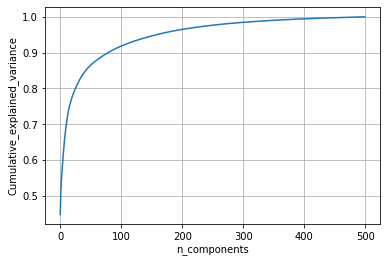

In [76]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 500)
svd_tfidf = svd.fit_transform(coocc_matrix)

percent_var_exp = svd.explained_variance_ / np.sum(svd.explained_variance_);
cum_var = np.cumsum(percent_var_exp)

plt.plot(cum_var)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

In [85]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 270)
svd_tfidf = svd.fit_transform(coocc_matrix)

### [5.4] Applying k-means clustering

Plotting elbow graph


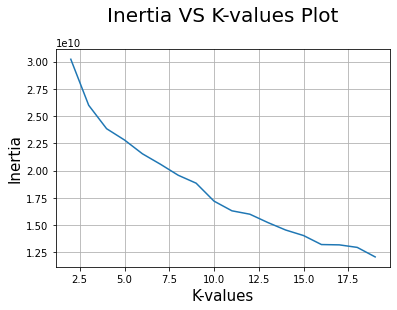




All clusters are [0 1 2 3 4 5 6 7]


word cloud for cluster 1


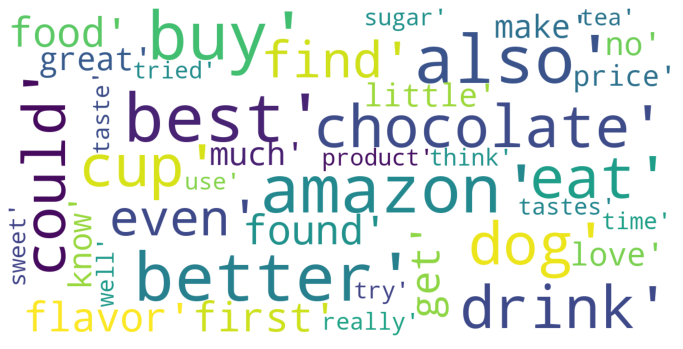




word cloud for cluster 2


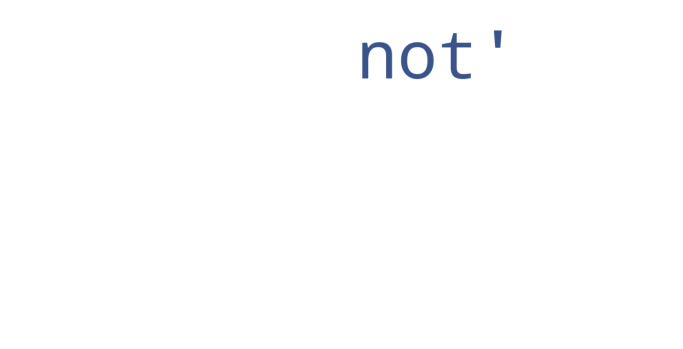




word cloud for cluster 3


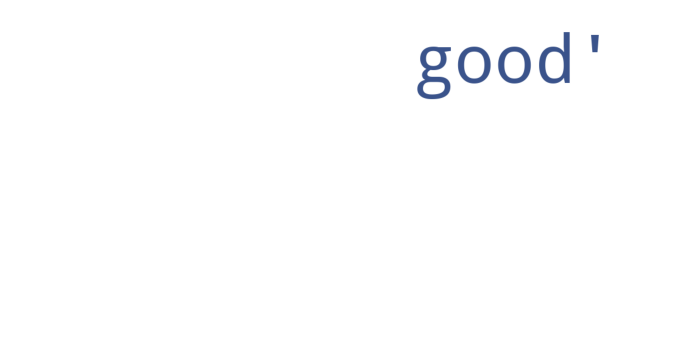




word cloud for cluster 4


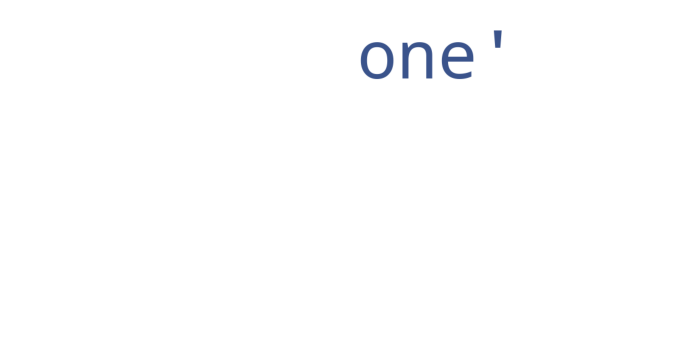




word cloud for cluster 5


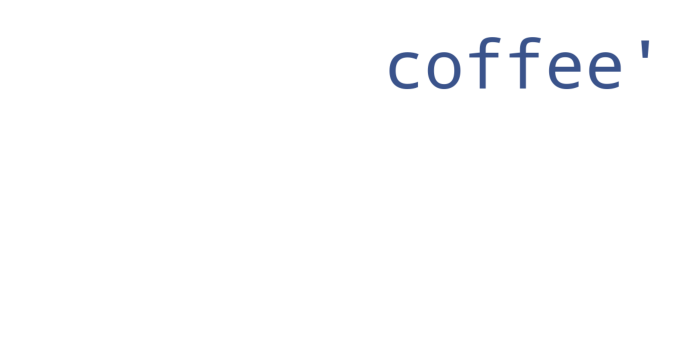




word cloud for cluster 6


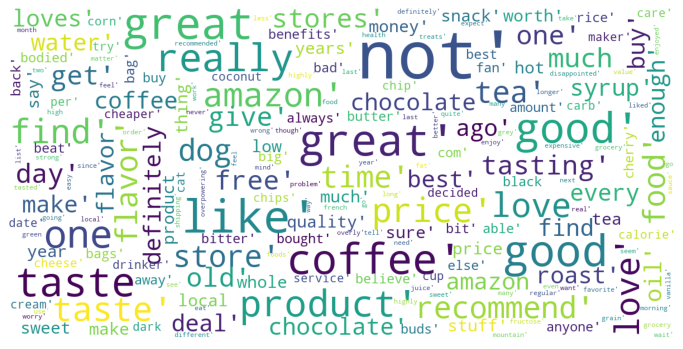




word cloud for cluster 7


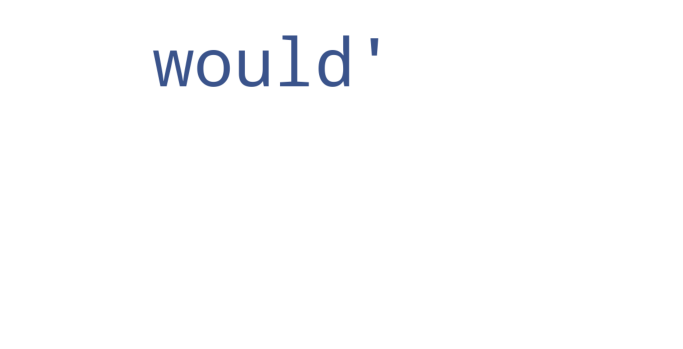




word cloud for cluster 8


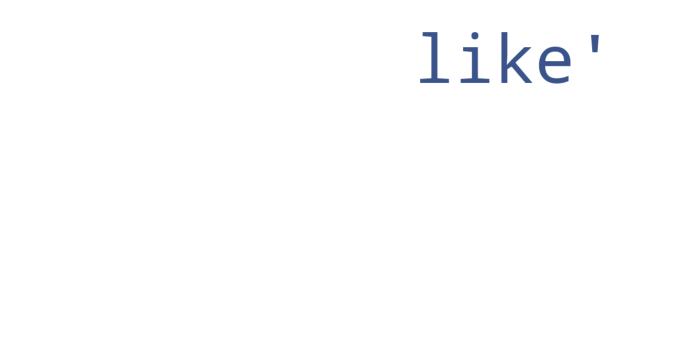

In [112]:
PrintWordcloud(tfidf_feat,svd_tfidf)

# Applying DBSCAN

In [113]:
#defining a fucntion to return inertia for every set of cluster center used
'''
https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc#:~:text=In%20layman's%20terms%2C%20we%20find,and%20select%20that%20as%20epsilon.
'''
def NeighborsDist(data,Min_pt=10):
  from sklearn.neighbors import NearestNeighbors
  nbrs = NearestNeighbors(n_neighbors=Min_pt).fit(data)
  distances, indices = nbrs.kneighbors(data)
  distances = np.sort(distances, axis=0)
  distances = distances[:,1][::-1]
  return distances


# plotting The Inertia vs K graph

def PlotElbowdb(data):
  plt.plot(data)
  plt.xlabel('Num_pts',size=15)
  plt.ylabel('Distance',size=15)
  plt.title('distance VS Num_pts Plot\n',size=20)
  plt.grid()
  plt.show()

  '''
Algorithm to find elbow of a graph is taken from the following questionare on Stackoverflow
#######
https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve
#######
'''

# finding the Elbow of graph

def ElbowFinderdb(Inertia):
  import numpy as np
  import numpy.matlib
  nPoints = len(Inertia)
  allCoord = np.vstack((range(nPoints), Inertia)).T
  np.array([range(nPoints), Inertia])
  firstPoint = allCoord[0]
  lineVec = allCoord[-1] - allCoord[0]
  lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
  vecFromFirst = allCoord - firstPoint
  scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
  vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
  vecToLine = vecFromFirst - vecFromFirstParallel
  distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
  return np.argmax(distToLine)






from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

# Generating word cloud function for a given dataset of str

def ShowWordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    
    
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()  



# overall function to generate graph and word cloud

def PrintWordclouddb(preprocessed_reviews,vectorizer,samples=50):

  nbr=NeighborsDist(vectorizer,Min_pt=samples)
  print('Plotting Epsilon graph')
  PlotElbowdb(nbr)
  print('\n\n')
  print('eps =',ElbowFinderdb(nbr))
  print('\n\n')


  from sklearn.cluster import DBSCAN

  clf = DBSCAN(min_samples=samples,eps=ElbowFinderdb(nbr))
  model=clf.fit(vectorizer)
  
  labels=model.labels_

  unq_labels=np.unique(labels)
  print('All clusters are',unq_labels)
  print("\n")

  corpus = preprocessed_reviews
  ListOfReviewsClusters=[[] for i in unq_labels]

  for index,word in enumerate(corpus):
    real_label = labels[index]
    ListOfReviewsClusters[real_label].append(word) 

  for i in range(len(list(unq_labels))):
    print('word cloud for cluster',i-1)
    ShowWordcloud(ListOfReviewsClusters[i])
    print('\n\n')
       

Plotting Epsilon graph


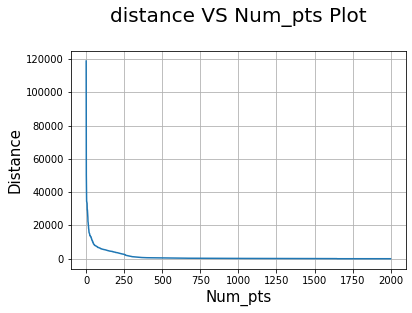




eps = 76



All clusters are [-1  0]


word cloud for cluster -1


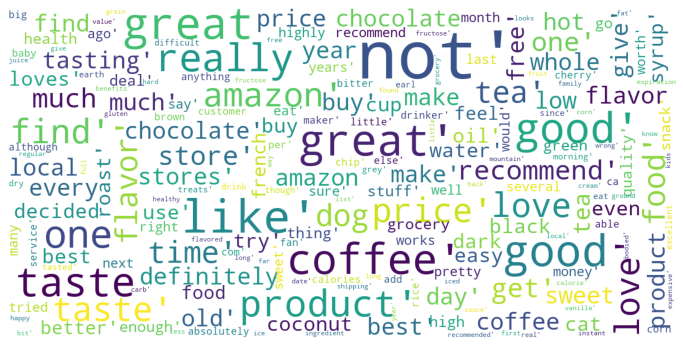




word cloud for cluster 0


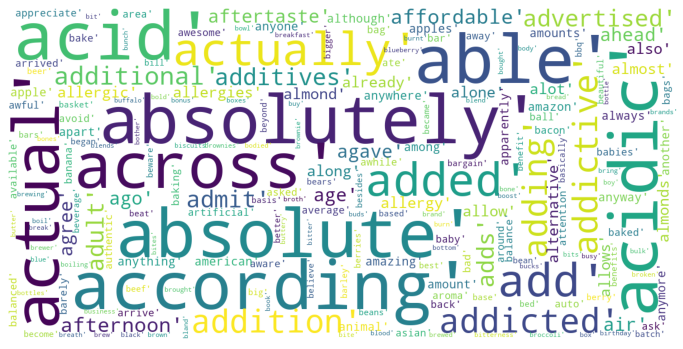

In [114]:
PrintWordclouddb(tfidf_feat,svd_tfidf)

### [5.6] Function that returns most similar words for a given word.

In [150]:
# Calculate cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(word, corpus):
  dist=[]
  for wd in corpus:
    dist.append(float(cosine_similarity(word.reshape(1,-1),wd.reshape(1,-1))))

  indices = np.argsort(dist)
  print(' Top 5 similar words are \n')
  for i in range(5):
    print(tfidf_feat[indices[i]])


In [152]:
cos_sim(svd_tfidf[120].reshape(1,-1),svd_tfidf)

 Top 5 similar words are 

best price
anything else
add little
bitter taste
big fan


In [153]:
cos_sim(svd_tfidf[485].reshape(1,-1),svd_tfidf)

 Top 5 similar words are 

absolutely love
also not
amazon price
able find
baby food


# [6] Conclusions

We took the usual Amazon fine food reviews data and 100000 reviews from it. Vectorized it with top 2000 words using IDF count. With this vector we formulate the Co-occurance matrix of words. Each vector is represented here in 2000 dimensions. To reduce this dimension to a resonable size and formulate a good word to vector form we input this data to SVD to reduce the dim with most variance intacted. We find 270 to be a good dimension size for data representation, and with kmeans clusting we found 6 cluters in which the data can be seggregated to while DBSCAN can seggregate the data into 2 clusters only.